In [1]:
from pathlib import Path
from glob import glob

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from rdkit import Chem
from rdkit.Chem import AllChem

from data_preparation import partition_data_by_continious_var, visualize_partition, create_tasks_asin_publ, evaluate_partitioning
import ml_utils

from NegativeClassOptimization import visualisations

/opt/homebrew/anaconda3/envs/nco/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Change data inputs here

In [ ]:
# define your data sources
DATA_DIR_PATH =  Path("./data/KIBA_selected")
data_files = glob(str(DATA_DIR_PATH / "*_KIBA.csv"))

#describe what are the following
CONT_VAR_NAME = 'Y' 
TARGET_ID_COL = 'Target_ID'
X_COL_NAME = 'Drug'

TASKS = ['vs_weak', 'shuffled_weak', 'vs_non_binder', 'shuffled_non_binder', 'vs_all', 'shuffled_all']
splits = [0, 1, 2, 42]

## Evaluate data

Note: 
* We recommend having datasets for at least two targets to allow the creation of either "vs. 1" or "vs. all" tasks.
* In this study we worked with balanced binary datasets.

Below, we divide each target-specific dataset into three bins based on continuous binding characteristics: binders, weak negatives, and non-binder negatives, and assign binary labels accordingly. Here, we split the data equally, but you may choose to adjust the cutoffs for each class. Additionally, we can visualize how these classes relate to each other in terms of continuous value distribution, allowing us to observe how the selected thresholds correspond visually to the data distribution.

We binarize continuous values because we aim to mimic the currently available datasets in the immune-receptor field, which are primarily binary or semi-quantitative, and assess whether this is sufficient to capture the rules of binding.

Number of samples: 1010,  Fair partition size: 336
Number of samples in Binder bin: 369, Number of samples in Weak bin: 311, Number of samples in Non-binder bin: 330
Largest bin sizes ratio: 1.19


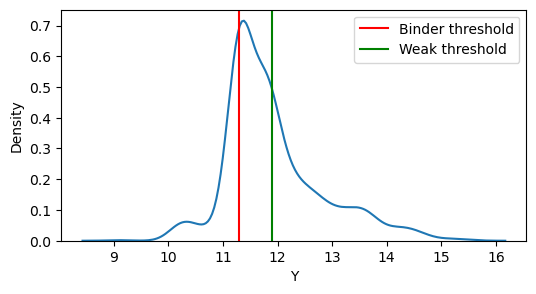

Number of samples: 1006,  Fair partition size: 335
Number of samples in Binder bin: 349, Number of samples in Weak bin: 327, Number of samples in Non-binder bin: 330
Largest bin sizes ratio: 1.07


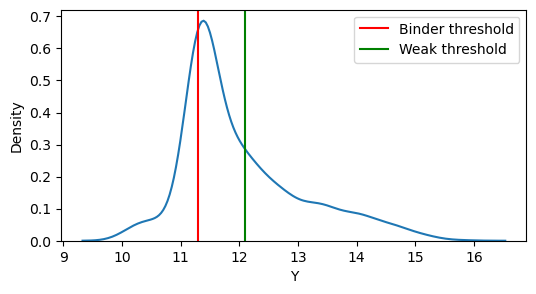

Number of samples: 1000,  Fair partition size: 333
Number of samples in Binder bin: 372, Number of samples in Weak bin: 299, Number of samples in Non-binder bin: 329
Largest bin sizes ratio: 1.24


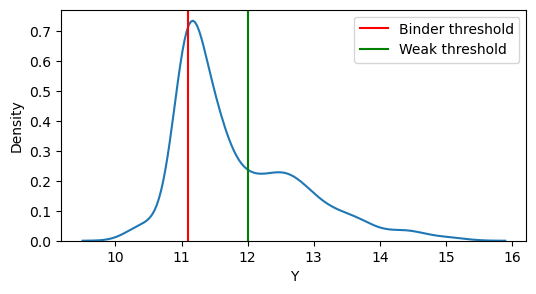

Number of samples: 1090,  Fair partition size: 363
Number of samples in Binder bin: 421, Number of samples in Weak bin: 335, Number of samples in Non-binder bin: 334
Largest bin sizes ratio: 1.26


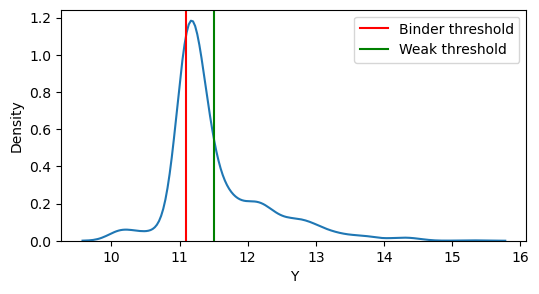

Number of samples: 1203,  Fair partition size: 401
Number of samples in Binder bin: 491, Number of samples in Weak bin: 329, Number of samples in Non-binder bin: 383
Largest bin sizes ratio: 1.49


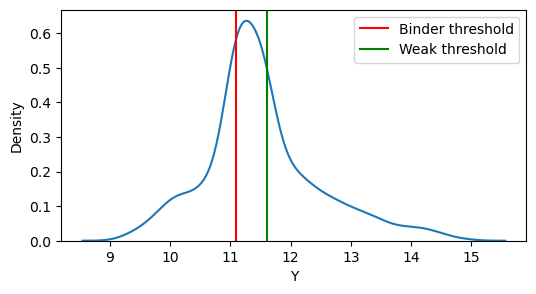

Number of samples: 1168,  Fair partition size: 389
Number of samples in Binder bin: 420, Number of samples in Weak bin: 373, Number of samples in Non-binder bin: 375
Largest bin sizes ratio: 1.13


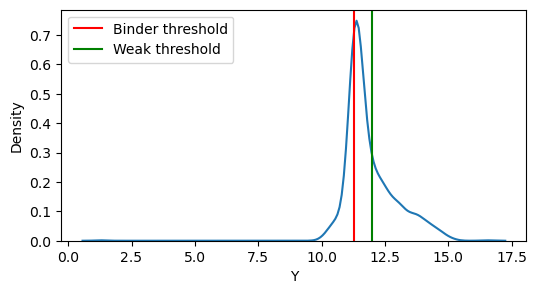

Number of samples: 1135,  Fair partition size: 378
Number of samples in Binder bin: 379, Number of samples in Weak bin: 416, Number of samples in Non-binder bin: 340
Largest bin sizes ratio: 1.22


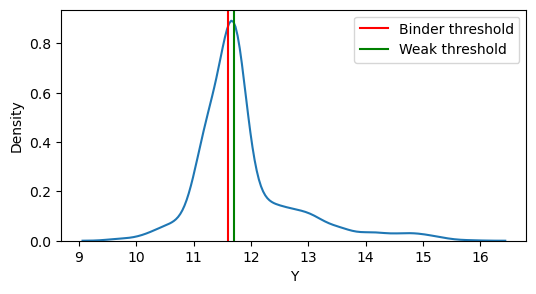

In [3]:
# Define paths
PATH_TO_PROSSED_DATA = Path(DATA_DIR_PATH) / 'processed'
PATH_TO_PROSSED_DATA.mkdir(parents=True, exist_ok=True)

processed_dfs_list = []
for data_file_path in data_files:
    data_file_path = Path(data_file_path)
    df = pd.read_csv(data_file_path)
    dataset_name = data_file_path.name

    # Partition
    processed_df, binder_thr, weak_thr = partition_data_by_continious_var(df, CONT_VAR_NAME)

    # Save partitioned data
    processed_df.to_csv(PATH_TO_PROSSED_DATA / dataset_name, index=False)
    processed_dfs_list.append(processed_df)

    # Evaluate partitioning
    n, n_binder, n_weak, n_non_binder, class_ratio, n_fair = evaluate_partitioning(processed_df, verbose=True)

    # Visualize the separation
    visualize_partition(processed_df, CONT_VAR_NAME, binder_thr, weak_thr)

df_all_targets = pd.concat(processed_dfs_list, ignore_index=True)

In [4]:
targets = df_all_targets[TARGET_ID_COL].unique()
targets

array(['Q13627', 'Q96GD4', 'Q13464', 'P11309', 'O94806', 'P49841',
       'P06239'], dtype=object)

## Create ML tasks

Note: tasks belong to binary classification. All datasets are fairly balanced.

In [9]:
PATH_TO_TASK_SPEC_DATA = PATH_TO_PROSSED_DATA / 'tasks_unsplit'
PATH_TO_TASK_SPEC_DATA.mkdir(parents=True, exist_ok=True)

for target in targets:

    #create tasks (train and test joined for now)
    df_vs_weak, df_shuffled_weak, df_vs_non_binder,  df_shuffled_non_binder, df_vs_all,  df_shuffled_all = create_tasks_asin_publ(df_all_targets, target, TARGET_ID_COL, X_COL_NAME )

    #save the data
    df_vs_weak.to_csv(PATH_TO_TASK_SPEC_DATA / f'{target}_vs_weak.csv', index=False)
    df_shuffled_weak.to_csv(PATH_TO_TASK_SPEC_DATA / f'{target}_shuffled_weak.csv', index=False)

    df_vs_non_binder.to_csv(PATH_TO_TASK_SPEC_DATA / f'{target}_vs_non_binder.csv', index=False)
    df_shuffled_non_binder.to_csv(PATH_TO_TASK_SPEC_DATA / f'{target}_shuffled_non_binder.csv', index=False)

    df_vs_all.to_csv(PATH_TO_TASK_SPEC_DATA / f'{target}_vs_all.csv', index=False)
    df_shuffled_all.to_csv(PATH_TO_TASK_SPEC_DATA / f'{target}_shuffled_all.csv', index=False)

## Prepare train and test splitting

In [ ]:
for target in targets:
    PATH_TO_SPLITS = PATH_TO_PROSSED_DATA / target
    PATH_TO_SPLITS.mkdir(parents=True, exist_ok=True)

    paths_to_tasks = glob(str(PATH_TO_TASK_SPEC_DATA/f'{target}*'))
    for path in paths_to_tasks:
        task = path.split('/')[-1].split('_')[1:]
        task = '_'.join(task)
        task = task.split('.')[0]

        #create folder to save target specific target splits
        path_to_save_task_splits = PATH_TO_SPLITS / task 
        path_to_save_task_splits.mkdir(parents=True, exist_ok=True)

        df_task = pd.read_csv(path)

        #create and save splits
        ml_utils.create_splits(df_task, path_to_save_task_splits, splits, test_size=0.2)

## Encode your data (if needed) and train the model

Use the encoding you prefer. \
For example you can perform One-hot encoding using ml_utils.one_hot_encode

In [ ]:
#Chemberta encoding
closed_perf_list = []
for target in targets:
    for task in TASKS:
        for split in splits:
            path_to_save_task_splits = Path(PATH_TO_PROSSED_DATA / f'{target}/{task}/split_{split}')
            df_train = pd.read_pickle(path_to_save_task_splits / 'train.pkl')

            X_train, X_train_enc_mean = ml_utils.chembert_encode(df_train, X_COL_NAME)
            y_train = df_train['Y_binary']

            path_to_save_model = path_to_save_task_splits / 'catboost_model_final.cbm'
            model = ml_utils.train_catboost_by_task(X_train,y_train, path_to_save_model)

            df_test = pd.read_pickle(path_to_save_task_splits / 'test.pkl')
            y_test = df_test['Y_binary']
            X_test, X_test_enc_mean = ml_utils.chembert_encode(df_test,X_COL_NAME, padding=True)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            closed_perf_list.append([target, task, split, acc])
            

In [9]:
df_closed = pd.DataFrame(closed_perf_list, columns=["target", "train_task", "split", "accuracy"])

Quick sanity check that shuffled negative controls have lower ID (can be omited, we will se the same result later)

NameError: name 'visualisations' is not defined

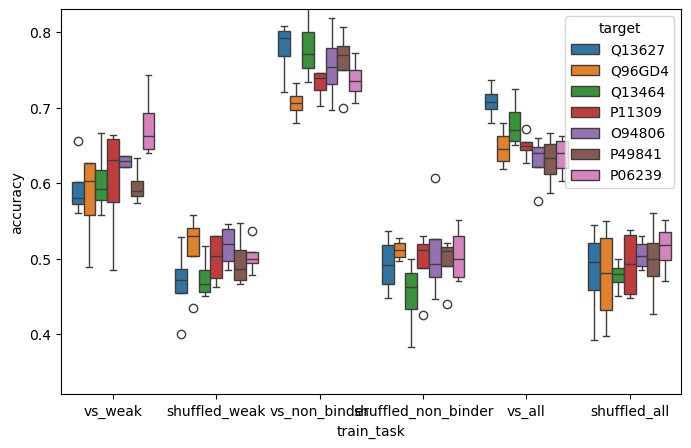

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_closed, x="train_task", y="accuracy", hue="target", order=TASKS, ax=ax)
plt.ylim(0.32,0.83)
visualisations.add_median_labels(ax, y_level=0.35, fontsize=8)
ax.set_ylabel("Closed accuracy")
ax.set_xlabel("Task")


## ID and OOD testing

In [ ]:
records = []
for target in targets:
    for split in splits:
        for train_task in TASKS:
            path_model = PATH_TO_PROSSED_DATA / target / train_task / f'split_{split}' / 'catboost_model_final.cbm'
            model = ml_utils.load_trained_model(path_model)

            for test_task in TASKS:
                path_to_target = PATH_TO_PROSSED_DATA / target
                path_vs_task_split = path_to_target / test_task / f'split_{split}'
                path_to_test = path_vs_task_split / 'test.pkl'
                test_dataset = pd.read_pickle(path_to_test)
                
                X_test, X_test_mean =  ml_utils.chembert_encode(test_dataset, 'Drug') #ok, it seems I need to fix this problem now
                y_test = test_dataset["Y_binary"]
                
                y_pred = model.predict(X_test)
                acc_test = accuracy_score(y_test, y_pred)

                records.append([target, train_task, test_task, split, acc_test])

In [17]:
de_perf_all = de_perf_all = pd.DataFrame(records, columns=["target", "train_task", "test_task", "split", "accuracy"])

## Visualize ID and OOD performance

In [19]:
task_order = ['vs_weak',
 'vs_non_binder',
 'vs_all',
 'shuffled_weak',
'shuffled_non_binder',
 'shuffled_all']

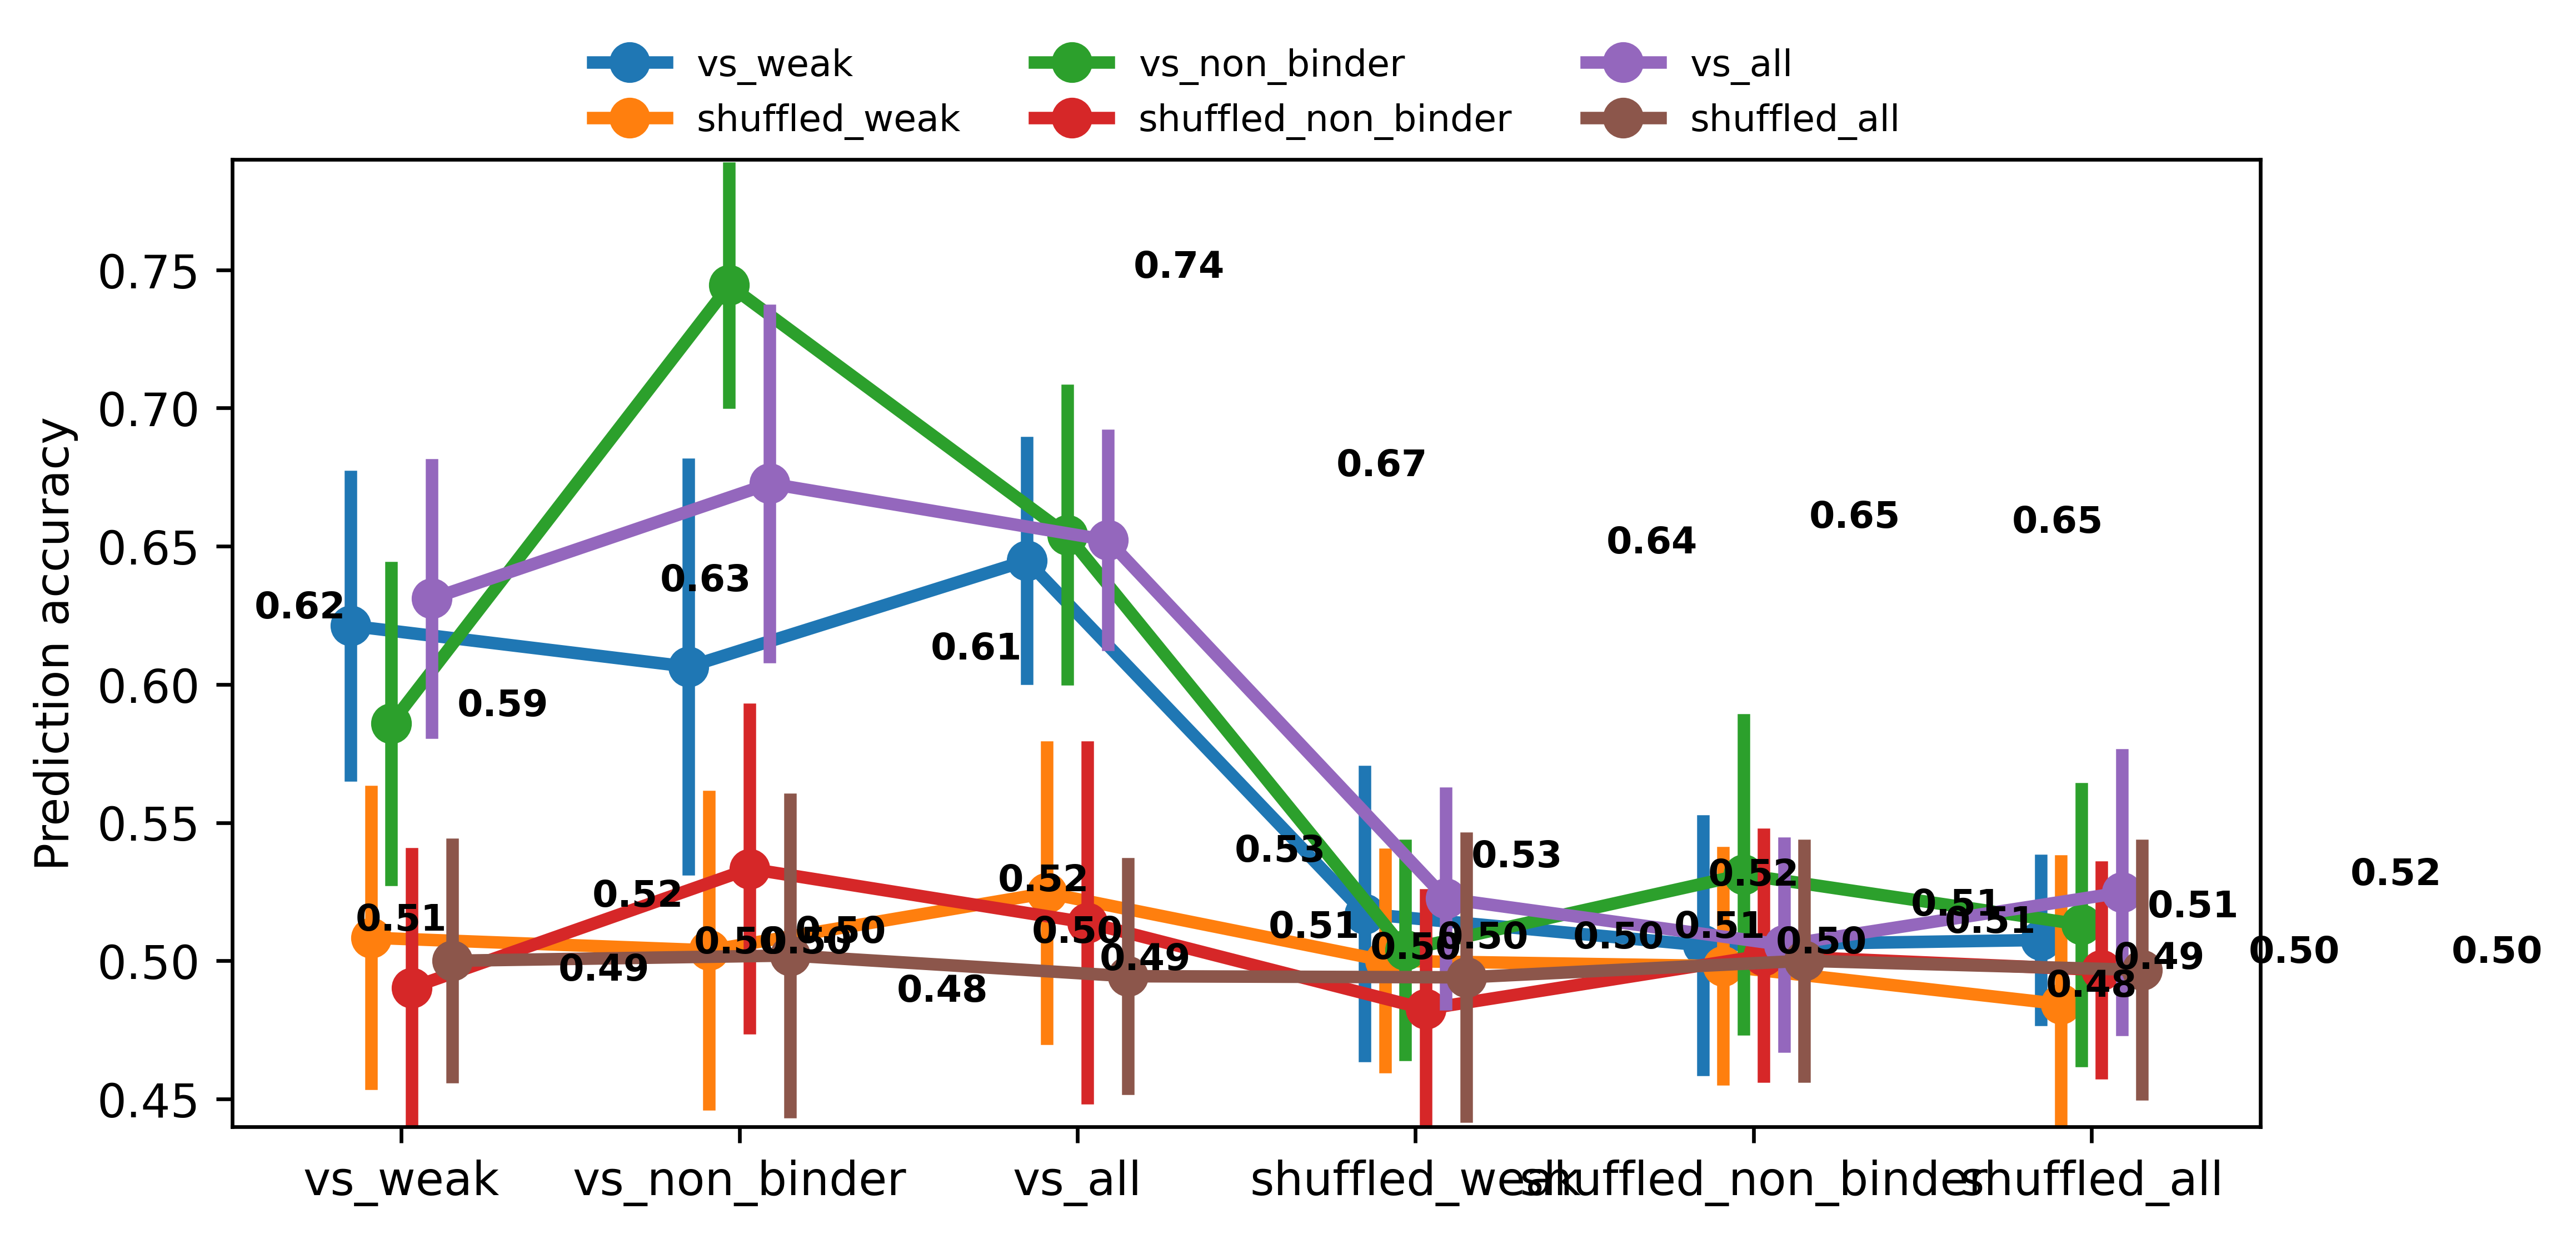

In [ ]:
plt.rcParams['svg.fonttype'] = 'none'

fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.2 * 3.14), dpi=600)
sns.pointplot(
    de_perf_all,
    y="accuracy",
    x="test_task",
    errorbar="sd",
    hue="train_task",
    dodge=0.3,
    ax=ax,
    estimator = "median",
    order = task_order

)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")
ax.set_ylim(0.44, 0.79)

# Add text mediam values
# Add text median values
medians = de_perf_all.groupby(['test_task', 'train_task'])['accuracy'].median().reset_index()
for i, row in medians.iterrows():
    test_task = row['test_task']
    train_task = row['train_task']
    median_val = row['accuracy']
    x = ax.get_xticks()[list(de_perf_all['test_task'].unique()).index(test_task)]
    hue_offset = list(de_perf_all['train_task'].unique()).index(train_task) * 0.3 - 0.3
    ax.text(
        x + hue_offset,
        median_val,
        f"{median_val:.2f}",
        ha="center",
        va="bottom",
        color="black",
        fontsize=8,
        fontweight="bold",
    )

fig.savefig('./figures/small_molec_ood.svg')

